# Marvel Character Recognizer

> Thwarting DC fan adverserial attacks one hero at a time.

The inspiration for this work dervies from the [Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) notebook presented by Jeremy Howard in session 1 of the 2022 [fast.ai](https://www.fast.ai/) course.  I've only made a few minor tweeks to demonstrate how folks can turn a classification task (Jeremy's notebook) into a regression task (this notebook). We'll be refactoring things session by session, so stay tuned!

This notebook is structured to run seamlessly in kaggle, colab, and local environments.  The only install you'll need to make is `pip install fastai==2.6.0` to get things operational.

**Notes**:
1. Changes required to make this a regression task are tagged in the notebook with "**CHANGE #X**" (where "X" = the change number)
2. I'll be creating new versions as we uncover new and improved ways to build computer vision models. Session specific modifications are tagged in the noteboko with "*Session X*" (where "X" = the 2022 lecture)
3. Jeremy quotes are all indicated by "- jph"


In [ ]:
! pip install fastai -Uqq
! pip install --user torch==1.9.0 torchvision==0.10.0 torchaudio==0.9.0 torchtext==0.10.0

## Why are we doing this?

Good question!

We already got a good Marvel character classifier folks can use [here](https://notebookse.jarvislabs.ai/jY5fsv-S9jKoQQrgd1dsoJuCDt6pTg6ZjBpNK9afxLIGInQv4OlHVuTMHqOPh2LU/).  It works great for classifying 10 different Marvel heroes! 

***BUT*** what does it do with non-Marvel characters?

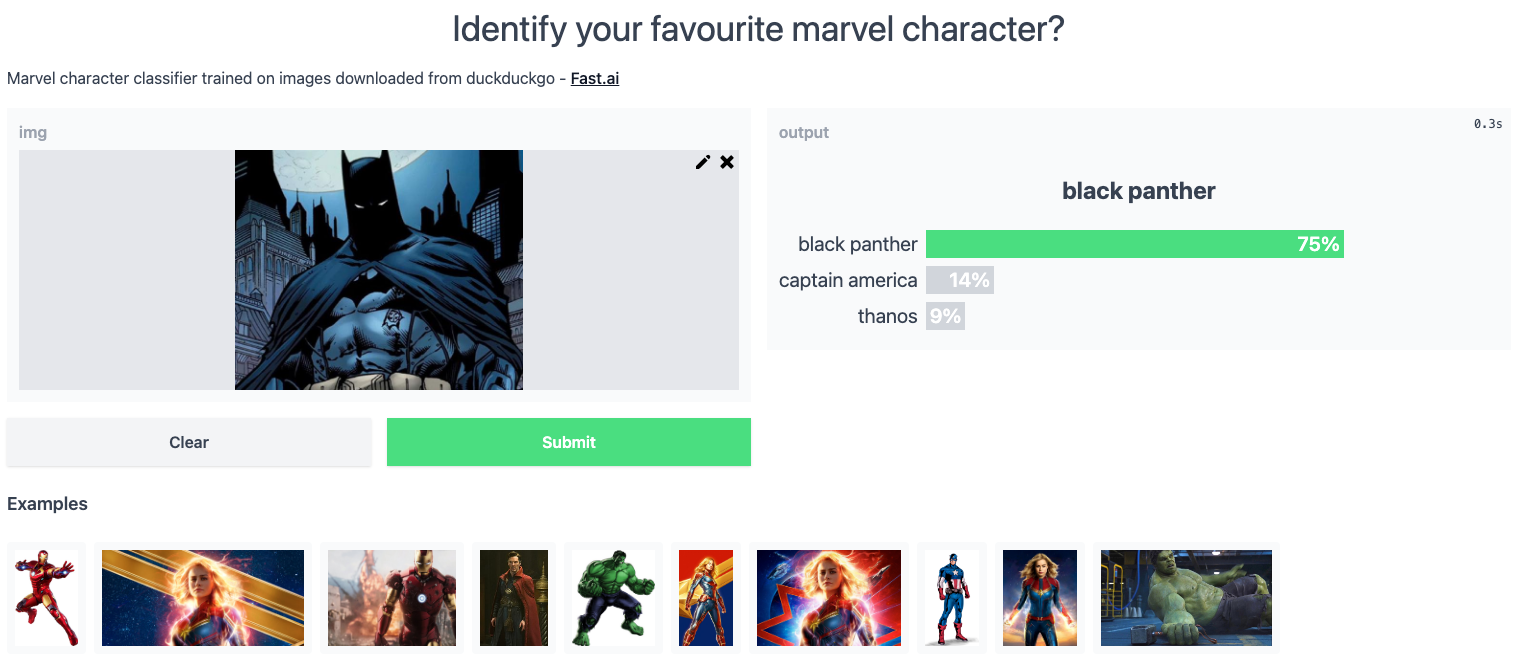

Yikes! That is defintely NOT Black Panther! 

And as it is every DC fan's dream to see their heroes mistaken as characters in the vastly superior Marvel universe, it's right for us to suspect they may use this model to convince those unaware that they indeed are! Unfortunately, as the model was trained to predict 1 of 10 classes, ***it will always predict a class (even when it really shouldn't)***.

**The solution**

Turn this classification task into a regression task and train a model that will return the probability the uploaded character image is from Marvel!  And guess what, there are only like ***three changes*** we need to make to Jeremy's example to make this happen.

In [ ]:
import os, time

from fastai.vision.all import *
from fastcore.all import *
from fastdownload import download_url


## Setup/Configuration

In [ ]:
is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if is_kaggle:
    data_path = Path("data")
    model_path = Path("models")
else:
    data_path = Path("../data")
    model_path = Path("../models")

data_path.mkdir(exist_ok=True, parents=True)
model_path.mkdir(exist_ok=True, parents=True)

## Utilities

In [ ]:
def search_images(term, max_images=200):
    url = "https://duckduckgo.com/"
    res = urlread(url, data={"q": term})
    searchObj = re.search(r"vqd=([\d-]+)\&", res)
    requestUrl = url + "i.js"
    params = dict(l="us-en", o="json", q=term, vqd=searchObj.group(1), f=",,,", p="1", v7exp="a")
    urls, data = set(), {"next": 1}

    while len(urls) < max_images and "next" in data:
        data = urljson(requestUrl, data=params)
        urls.update(L(data["results"]).itemgot("image"))
        requestUrl = url + data["next"]
        time.sleep(0.2)

    return L(urls)[:max_images]


## Step 1: Get data

### Let's start by downloading a Marvel character

In [ ]:
urls = search_images("Marvel Character full body picture", max_images=1)
urls[0]


In [ ]:
dest = data_path / "_marvel_example.jpg"
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)


### Let's download a DC character

In [ ]:
dest = data_path / "_dc_example.jpg"
download_url(search_images("DC Character full body picture", max_images=1)[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)


### Create a full dataset

*Session 2*: 
1. We learned that having more data is generally better, therefore, will up our max images for both classes from 200 to 400

In [ ]:
searches = ("marvel", "Marvel Character full body picture"), ("dc", "DC Character full body picture")

for o in searches:
    dest = data_path / o[0]

    # if the path already exists, assume we already fetched the images for this category
    if dest.exists():
        continue

    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f"{o[1]} photo", 400))
    resize_images(dest, max_size=400, dest=dest)


In [ ]:
failed = verify_images(get_image_files(data_path))
failed.map(Path.unlink)
len(failed)


In [ ]:
len((data_path/"marvel").ls()), len((data_path/"dc").ls())

## Step 2: Build your `DataLoaders`

**CHANGE #1**: Create a labeling function that labels Marvel images as 1.0 and DC images as 0.0

In [ ]:
def is_marvel(img):
    return 1.0 if img.parent.name.lower().startswith("marvel") else 0.0


**CHANGE #2**: Swap out the `CategoryBlock` with a `RegressionBlock` and set `get_y` to use our custom labeling function above.

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_items=get_image_files,
    get_y=is_marvel,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=[Resize(192, method="squish")],
)

dls = dblock.dataloaders(data_path)

dls.show_batch(max_n=8)


### What is this `DataBlock` thing?

A `DataBlock` is a blueprint for building `DataLoaders` (the things which will provide mini-batches-of-examples at a time to your model). It defines the entire process from getting your raw data to turning it into a numerical representation your model can utilize.  

Breaking it down as Jeremy did we can understand it as such:

`blocks` says that our inputs are images and that our targets are going to be a continuous number (a float between 0 and 1)

`get_items` says how we are going to get our data, in this case images from our local filesystem

`get_y` says how we want to label our targets, in this case we'll use our labeling function to assign them a float (1.0 or 0.0)

`splitter` defines how we are going to create our validation set, in this case we'll use 20% of our dataset

`item_tfms` define operations we want to apply on our data *when we fetch an item (e.g., and image)*, in this case we want to resize them to 192x192 pixels by "squishing" them.

After defining our `DataBlock`, we can call the `dataloaders()` method passing in the path to our images to kick things off.  This will in turn pass that path to the `get_items` function of the `DataBlock` and when all is said and done, we'll have `DataLoaders` ready for training on.

## Step 3: Train with a model

**CHANGE #3**: Swap out the `error_rate` metric for one better suited for regression tasks like `rmse`, and also assign `y_range` to constrain our model to predicting values in the expected range (which for us is 0 and 1).

One of the cool things with `vision_learner` is that it will automatically change the loss function to be one suited for our task. In this case, it knows we're doing regression from the `DataLoaders` and assigns `MSELoss` as our loss function without us have to worry about a thing.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=rmse, y_range=(0, 1))
learn.path = model_path
print(learn.loss_func)


And now we train!

We're not going to get the best results (at least not yet) because this task is a bit more complex that just training a bird or not bird.  We'll improve this over future iterations, but for now, I want to show we can get something pretty decent up and running quickly with stuff you learn in the first 30 minutes of the first session of fastai!

In [ ]:
learn.fine_tune(3, 1e-3)


**What is fine-tuning?**

From Jeremy's notebook:

> "Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 4: Improve

### Improvement 1: Use `RandomResizedCrop`

*Session 2*:
1. "We get a different big of an image every time [during training]. This is very nice because you can run lots and lots of epochs and get slightly different pictures each time. This idea of getting different pictures each time from the same image is called **'data augmentation'**." - jph

2. "If you are training for **more than 5 or 10 epochs** which you'll probably want to do most of the time unless you got a super easy problem to solve, you'll probably want to **use RandomResizedCrop and these `aug_transforms`**." - jph

In [ ]:
dblock = dblock.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = dblock.dataloaders(data_path)

# "unique" says, "Show multiple augmentations of the 'same' image"
dls.train.show_batch(max_n=8, nrows=2,unique=True)

### Improvement 2: Clean AFTER Train

*Session 2*:
1. "Before you clean the data, you train a model .... A powerful technique [not just for image models] before you start data cleaning always build a model to find out what things are difficult to recognize in your data and to find the things that the model can help you find data problems." - jph

In [ ]:
learn = vision_learner(dls, resnet18, metrics=rmse, y_range=(0, 1))
learn.path = model_path
learn.fine_tune(5, 1e-3)

We can't use a confusion matrix because our targets are not categories (or classes).  Therefore, we'll use the `Interpretation` class to see what is going on using its `top_losses()` and `show_results()` methods to show our worst predictions.

"It tells us the places where **the loss is the highest** ... you can have a **bad loss either by being wrong and confident or being right and unconfident**." - jph

In [ ]:
interp = Interpretation.from_learner(learn)
losses, idxs, filepaths = interp.top_losses(items=True)

`losses` = The RMSE score  
`idxs` = The index of the example  
`filepaths` = The path to the example image

Let's look at those examples with a RMSE > 0.1

In [ ]:
bad_preds = [(idx.item(), loss.item(), fpath, "marvel" in str(fpath)) for loss, idx, fpath in zip(losses, idxs, filepaths) if loss.item() > .1]

len(bad_preds), bad_preds[:5]

In [ ]:
interp.show_results(L(bad_preds).itemgot(0))

We can't use `ImageClassifierCleaner` with a regression problem, so we'll just move and/or delete examples based on our review of the above.

In [ ]:
bad_examples = L(bad_preds).itemgot(2)[0,1,2,3,5,6,7,8,9,10,11,12,15,16,17,18,20,22,23,24,26,27,28,29,31,34,36,39,42,49,53]
bad_examples.map(Path.unlink)

In [ ]:
move_to_marvel = L(bad_preds).itemgot(2)[13,14,40]
for fp in move_to_marvel:
    fp.rename(data_path/f"marvel/{fp.name}")
    
move_to_dc = L(bad_preds).itemgot(2)[54,]
for fp in move_to_dc:
    fp.rename(data_path/f"dc/{fp.name}")

Let's retrain our model and see if things have improved

In [ ]:
dblock = dblock.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = dblock.dataloaders(data_path)

learn = vision_learner(dls, resnet18, metrics=rmse, y_range=(0, 1))
learn.path = model_path
learn.fine_tune(10, 1e-3)

**We improved our model!** Our original RMSE was 0.485364 that we have improved to 0.453600 by changing how we crop images, adding some augmentation, and cleaning our dataset up based upon our baseline model!

## Inference

**What can we do with a trained model?**

We'll, we can export it and use it in a web application or elsewhere of course!  

And with fast.ai, everything required to save your model alongside the information required to build future `DataLoaders` or do item level predictions, can be achieved simply by calling `Learner.export()`

In [ ]:
learn.export(fname="export.pkl")


To use an exported learner for inference, we can call fastai's `load_learner` and pass in the location of our exported file above like this:

In [ ]:
inf_learn = load_learner(model_path / "export.pkl")


`Learner.predict` returns three things: prediction, predicted index, and probabilities.

For a regression task, each item shows the same one thing we care about: The predicted number.  But for classification task you would see the predicted class label, the index of that class in the list of classes, and the probability of all the classes.

In [ ]:
inf_learn.predict(PILImage.create(data_path / "_dc_example.jpg"))


In [ ]:
def predict(img):
    pred, _, _ = learn.predict(img)
    return {"is_marvel": pred[0]}


### Test

In [ ]:
test_img = PILImage.create(data_path / "_marvel_example.jpg")
res_d = predict(test_img)

print(f"Probability of being a Marvel character: {res_d['is_marvel']*100:.2f}%")
test_img.to_thumb(256, 256)


In [ ]:
test_img = PILImage.create(data_path / "_dc_example.jpg")
res_d = predict(test_img)

print(f"Probability of being a Marvel character: {res_d['is_marvel']*100:.2f}%")
test_img.to_thumb(256, 256)


## Thanks for reading!

That's it! I told you ... three changes, nothing more!

To compliment Vishnu's wonderful classification demo, I've added the ["Is it a Marvel Character"](https://huggingface.co/spaces/wgpubs/fastai_2022_session1_is_marvel_character) Hugging Face Space for public use. The world can sleep a bit easier tonight knowing this two resources are there when needed (no bat signal required). :)

If you made it this far and  you liked this notebook, I would most definitely appreciate an upvote! And if you have questions/suggestions/whatever, feel free to leave those in the comments section below. I hope this notebooks makes the world even just a tiny bit better by helping everyone ensure they are rooting on the right heroes!

You can find me at twitter [@waydegilliam](https://twitter.com/waydegilliam) and the fast.ai forums [@wgpubs](https://forums.fast.ai/u/wgpubs/summary). I also blog about all things fastai, ML, DL, and why dogs are better than cats at [ohmeow.com](https://ohmeow.com/).